# `0020` OpenSeesPy

This notebook is adapted from the OpenSeesPy example at this [link](https://openseespydoc.readthedocs.io/en/latest/src/RCFrameGravity.html).

In [1]:
from openseespy.opensees import *
import openseespy.opensees as ops
import openseespy.postprocessing.ops_vis as opsv
import matplotlib.pyplot as plt

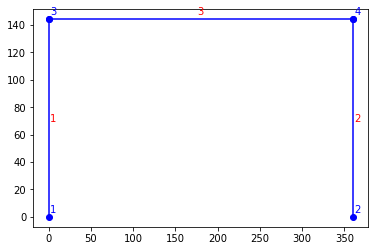

In [2]:
# Create ModelBuilder (with two-dimensions and 3 DOF/node)
ops.wipe()
ops.model('basic', '-ndm', 2, '-ndf', 3)

# Create nodes
# ------------

# Set parameters for overall model geometry
width = 360.0
height = 144.0

# Create nodes
#    tag, X, Y
ops.node(1, 0.0, 0.0)
ops.node(2, width, 0.0)
ops.node(3, 0.0, height)
ops.node(4, width, height)

# Fix supports at base of columns
#   tag, DX, DY, RZ
ops.fix(1, 1, 1, 1)
ops.fix(2, 1, 1, 1)

# Define materials for nonlinear columns
# ------------------------------------------
# CONCRETE                   tag  f'c    ec0    f'cu   ecu
# Core concrete (confined)
uniaxialMaterial('Concrete01', 1, -6.0, -0.004, -5.0, -0.014)

# Cover concrete (unconfined)
uniaxialMaterial('Concrete01', 2, -5.0, -0.002, 0.0, -0.006)

# STEEL
# Reinforcing steel
fy = 60.0;  # Yield stress
E = 30000.0;  # Young's modulus
#                         tag  fy E0    b
uniaxialMaterial('Steel01', 3, fy, E, 0.01)

# Define cross-section for nonlinear columns
# ------------------------------------------

#  some parameters
colWidth = 15
colDepth = 24

cover = 1.5
As = 0.60  # area of no. 7 bars

# some variables derived from the parameters
y1 = colDepth / 2.0
z1 = colWidth / 2.0

section('Fiber', 1)

# Create the concrete core fibers
patch('rect', 1, 10, 1, cover - y1, cover - z1, y1 - cover, z1 - cover)

# Create the concrete cover fibers (top, bottom, left, right)
patch('rect', 2, 10, 1, -y1, z1 - cover, y1, z1)
patch('rect', 2, 10, 1, -y1, -z1, y1, cover - z1)
patch('rect', 2, 2, 1, -y1, cover - z1, cover - y1, z1 - cover)
patch('rect', 2, 2, 1, y1 - cover, cover - z1, y1, z1 - cover)

# Create the reinforcing fibers (left, middle, right)
layer('straight', 3, 3, As, y1 - cover, z1 - cover, y1 - cover, cover - z1)
layer('straight', 3, 2, As, 0.0, z1 - cover, 0.0, cover - z1)
layer('straight', 3, 3, As, cover - y1, z1 - cover, cover - y1, cover - z1)

# Define column elements
# ----------------------

# Geometry of column elements
#                tag

geomTransf('PDelta', 1)

# Number of integration points along length of element
np = 5

# Lobatto integratoin
beamIntegration('Lobatto', 1, 1, np)

# Create the coulumns using Beam-column elements
#               e            tag ndI ndJ transfTag integrationTag
eleType = 'forceBeamColumn'
element(eleType, 1, 1, 3, 1, 1)
element(eleType, 2, 2, 4, 1, 1)

# Define beam elment
# -----------------------------

# Geometry of column elements
#                tag
geomTransf('Linear', 2)

# Create the beam element
#                          tag, ndI, ndJ, A,     E,    Iz, transfTag
element('elasticBeamColumn', 3, 3, 4, 360.0, 4030.0, 8640.0, 2)

# Define gravity loads
# --------------------

#  a parameter for the axial load
P = 180.0;  # 10% of axial capacity of columns

# Create a Plain load pattern with a Linear TimeSeries
timeSeries('Linear', 1)
pattern('Plain', 1, 1)

# Create nodal loads at nodes 3 & 4
#    nd  FX,  FY, MZ
load(3, 0.0, -P, 0.0)
load(4, 0.0, -P, 0.0)

opsv.plot_model()

In [3]:
# ------------------------------
# Start of analysis generation
# ------------------------------

# Create the system of equation, a sparse solver with partial pivoting
ops.system('BandGeneral')

# Create the constraint handler, the transformation method
ops.constraints('Transformation')

# Create the DOF numberer, the reverse Cuthill-McKee algorithm
ops.numberer('RCM')

# Create the convergence test, the norm of the residual with a tolerance of
# 1e-12 and a max number of iterations of 10
ops.test('NormDispIncr', 1.0e-12, 10, 3)

# Create the solution algorithm, a Newton-Raphson algorithm
ops.algorithm('Newton')

# Create the integration scheme, the LoadControl scheme using steps of 0.1
ops.integrator('LoadControl', 0.1)

# Create the analysis object
ops.analysis('Static')

# ------------------------------
# End of analysis generation
# ------------------------------

In [4]:
# ------------------------------
# perform the analysis
# ------------------------------

# perform the gravity load analysis, requires 10 steps to reach the load level
ops.analyze(10)

# Print out the state of nodes 3 and 4
# print node 3 4

# Print out the state of element 1
# print ele 1

u3 = nodeDisp(3, 2)
u4 = nodeDisp(4, 2)

if abs(u3 + 0.0183736) < 1e-6 and abs(u4 + 0.0183736) < 1e-6:
    print("Passed!")
else:
    print("Failed!")

Passed!


100

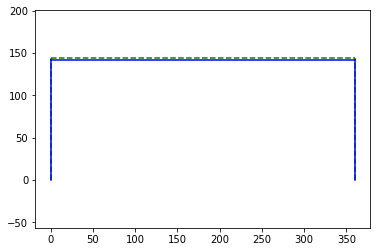

In [6]:
opsv.plot_defo(100)